In [2]:
import sys

sys.path.append("src/")
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from models import immoco, autofocusing, KLineDetect, af_plus, unet
from utils.motion_utils import extract_movement_groups
from utils.data_utils import IFFT, FFT
from utils.losses import GradientEntropyLoss
from utils.evaluate import calmetric2D


In [ ]:
kldenet = KLineDetect.get_unet(
    in_chans=2, out_chans=1, chans=32, num_pool_layers=4, drop_prob=0.0
).cuda()
kldenet.load_state_dict(torch.load("src/model_weghts/kLDNet.pth"))
kldenet.eval()


In [ ]:
# load a test expample for light motion
test_path = "Dataset/Brain/t2/test_files/_test_data_heavy.pth"
dataset = torch.load(test_path)

kspaces_motion = dataset["kspace_motion"]
images_rss = dataset["image_rss"]
real_masks = dataset["mask"]
metrics = dataset["metrics"]
print("Data loaded")
print("kspaces_motion shape:", kspaces_motion.shape)


In [ ]:
metrics = torch.load("results/immoco/immoco_metrics.pth")[1]
median_ssim = []
median_psnr = []

# get median over metrics
for i in range(len(metrics)):
    median_ssim.append(metrics[i]["ssim"])
    median_psnr.append(metrics[i]["psnr"])
print("Median SSIM:", torch.median(torch.tensor(median_ssim)).item())
print("Median PSNR:", torch.median(torch.tensor(median_psnr)).item())


In [ ]:
i = torch.median(torch.tensor(median_ssim), 0)[1].item()
print("Best SSIM:", i)
image_rss = images_rss[i]
kspace_motion = kspaces_motion[i].cuda()
image_motion = IFFT(kspace_motion)
real_mask = real_masks[i]


plt.imshow(image_rss.abs().squeeze(), cmap="gray")


Mask shape: torch.Size([19, 320, 320])


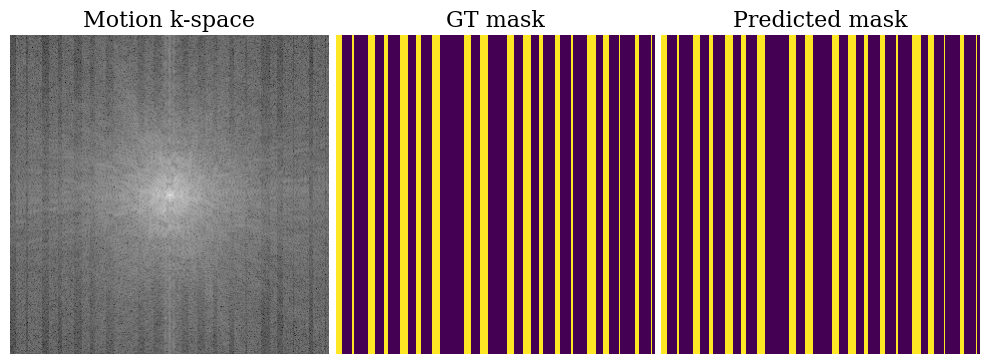

In [14]:
with torch.no_grad():
    mask = (
        kldenet(
            torch.view_as_real(kspace_motion).unsqueeze(0).permute(0, 3, 1, 2)
        ).sigmoid()
        > 0.5
    ).float()
    masks = extract_movement_groups(
        mask.squeeze().sum(0).div(mask.squeeze().shape[0]) > 0.2, make_list=True
    )
    mask = masks.sum(0).long()
print("Mask shape:", masks.shape)
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
# set the figure title
# fig.suptitle('klD-Net prediction of motion mask', fontsize=20, fontfamily='serif')
# plot the images
ax[0].imshow(kspace_motion.abs().add(1e-9).log().squeeze().cpu(), cmap="gray")
ax[0].set_title("Motion k-space", fontsize=16, fontfamily="serif")
ax[0].axis("off")
ax[1].imshow(real_mask, interpolation="nearest")
ax[1].set_title("GT mask", fontsize=16, fontfamily="serif")
ax[1].axis("off")
ax[2].imshow(mask.cpu(), interpolation="nearest")
ax[2].set_title("Predicted mask", fontsize=16, fontfamily="serif")
ax[2].axis("off")

plt.tight_layout(h_pad=0, w_pad=0.5)


In [ ]:
# test the autofocusing model
scale = kspace_motion.detach().abs().max()
k_space_test = kspace_motion.div(scale).mul(16000)

autofocusing_model = autofocusing.Autofocusing(masks.cuda()).cuda()
optim_af = torch.optim.Adam(autofocusing_model.parameters(), lr=1.0)

for j in range(100):
    optim_af.zero_grad()
    autofocusing_image = autofocusing_model(k_space_test.cuda())
    loss = GradientEntropyLoss()(IFFT(autofocusing_image))
    loss.backward()
    optim_af.step()


In [ ]:
# test Unet only
net = unet.Unet(
    in_chans=1,
    out_chans=1,
    chans=32,
    num_pool_layers=6,
    batchnorm=nn.InstanceNorm2d,
    drop_prob=0.0,
).cuda()
net.load_state_dict(torch.load("src/model_weghts/unet_denoising.pth"))
net.eval()

unet_img = net(IFFT(k_space_test).abs().unsqueeze(0).unsqueeze(0)).squeeze()


In [ ]:
# test afplus original
unet_model = unet.Unet(
    1, 1, 32, 6, batchnorm=torch.nn.InstanceNorm2d, init_type="none"
).cuda()
unet_model.load_state_dict(torch.load("src/model_weghts/AFPlus.pth"))
unet_model.eval()

afplus_img = af_plus.AFPLUS(k_space_test, unet_model)


In [120]:
# test immoco
immoco_image, forward_kspace = immoco.imcoco_motion_correction(
    kspace_motion, masks, learning_rate=1e-2, lambda_ge=1e-2, debug=False
)


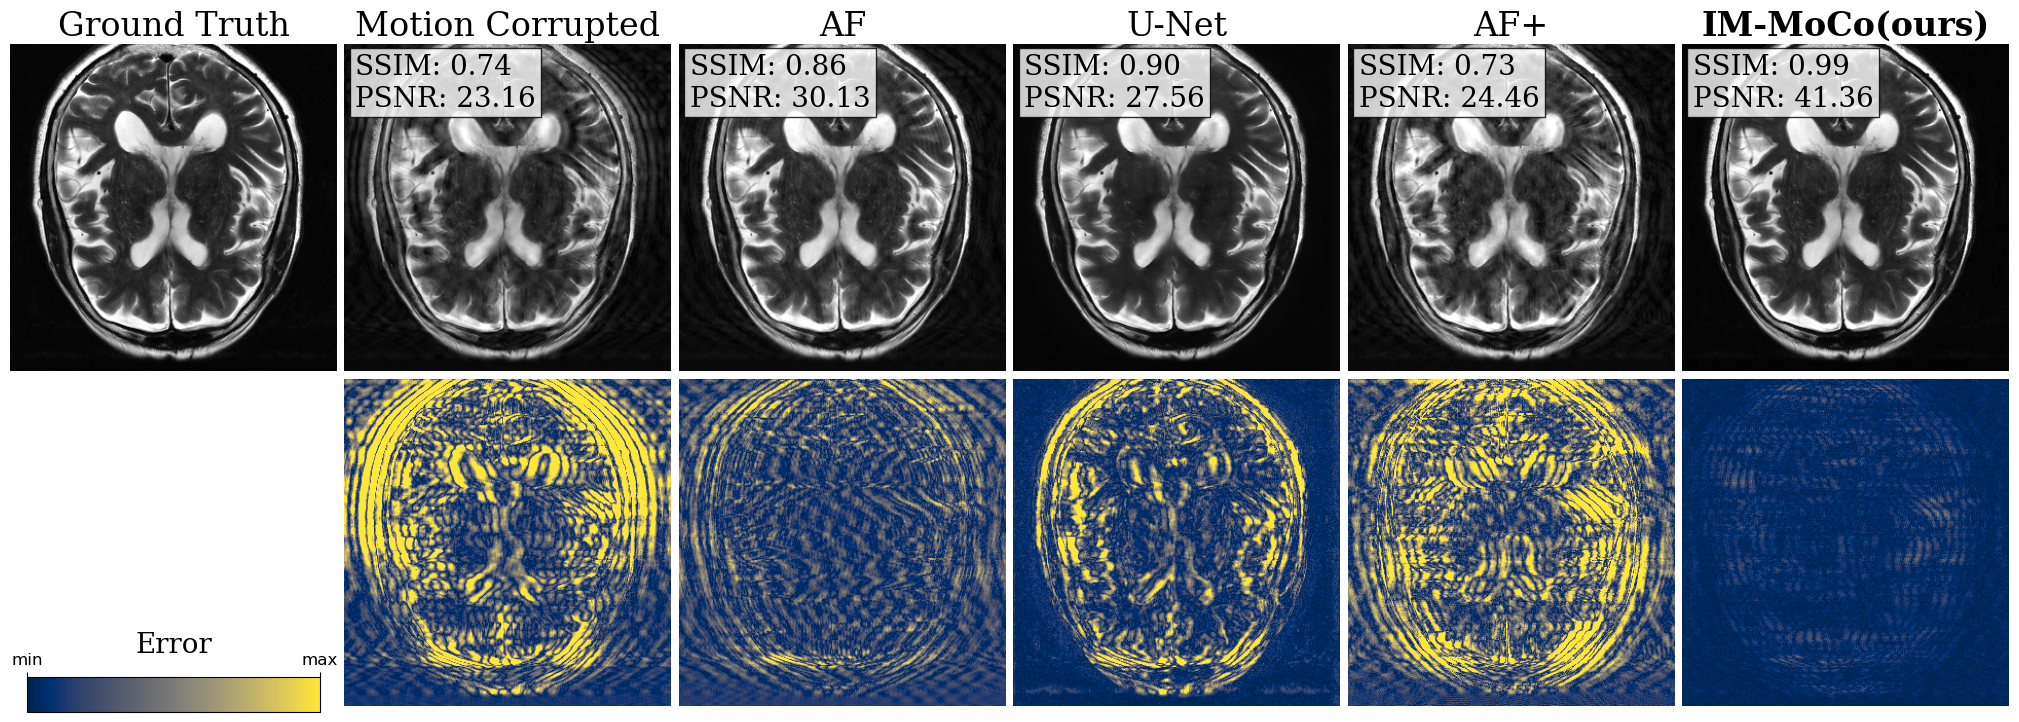

In [122]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage import exposure
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patheffects as path_effects

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset


def normalize01(x):
    return (x - x.min()) / (x.max() - x.min())


fn = lambda x: normalize01(x)


def display_and_compare_images(
    ground_truth, method_images, method_titles, crop_glob, figname="test.png"
):
    num_methods = len(method_images)
    fig, axes = plt.subplots(2, num_methods + 1, figsize=(20, 7))
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0.0, top=1)

    H, W = ground_truth.shape
    crop = [int(H / 4), int(W / 4)]
    ground_truth_crop = ground_truth[crop[0] : -crop[0], crop[1] : -crop[1]]
    ground_truth_crop = fn(ground_truth_crop)

    ground_truth = fn(ground_truth)
    # Display ground truth
    axes[0, 0].imshow(
        ground_truth[crop_glob:-crop_glob, crop_glob:-crop_glob],
        cmap="gray",
        vmin=0,
        vmax=0.8,
    )
    axes[0, 0].set_title("Ground Truth", fontsize=24, fontfamily="serif")
    axes[0, 0].margins(0, 0)
    axes[0, 0].axis("off")

    # Compute and display SSIM and PSNR for ground truth (no errors)
    axes[0, 0].axis("off")
    empyt_img = np.ones_like(ground_truth)
    im = axes[1, 0].imshow(empyt_img, cmap="magma", alpha=0.0)
    axes[1, 0].axis("off")

    # Loop through the method images
    for i in range(num_methods):
        # Display the method image
        method_image = method_images[i]
        method_img_crop = method_image[crop[0] : -crop[0], crop[1] : -crop[1]]
        method_img_crop = fn(method_img_crop)
        # Normalize contrast for better visualization
        # method_img_eq = exposure.equalize_hist(method_img)
        method_image = fn(method_image)
        im = axes[0, i + 1].imshow(
            method_image[crop_glob:-crop_glob, crop_glob:-crop_glob],
            cmap="gray",
            vmin=0,
            vmax=0.8,
        )
        if i == num_methods - 1:
            axes[0, i + 1].set_title(
                method_titles[i], fontsize=24, weight="bold", fontfamily="serif"
            )
        else:
            axes[0, i + 1].set_title(method_titles[i], fontsize=24, fontfamily="serif")
        axes[0, i + 1].margins(0, 0)
        axes[0, i + 1].axis("off")

        # Compute and display SSIM and PSNR for each method image

        ssim_val = ssim(ground_truth, method_image, data_range=1.0)
        psnr_val = psnr(ground_truth, method_image, data_range=1.0)
        info_text = f"SSIM: {ssim_val:.2f}\nPSNR: {psnr_val:.2f}"
        text = axes[0, i + 1].text(
            10,
            60,
            info_text,
            fontsize=20,
            color="black",
            fontfamily="serif",
            bbox=dict(facecolor="white", alpha=0.8, edgecolor="black"),
        )
        axes[0, i + 1].margins(0, 0)
        axes[0, i + 1].axis("off")

        # Compute and display the difference (error) between method image and ground truth
        error_img = np.abs(
            ground_truth[crop_glob:-crop_glob, crop_glob:-crop_glob]
            - method_image[crop_glob:-crop_glob, crop_glob:-crop_glob]
        )
        cax = axes[1, i + 1].imshow(error_img, cmap="cividis", vmin=0, vmax=0.1)
        axes[1, i + 1].axis("off")

    import matplotlib.cm as cm

    sm = cm.ScalarMappable(cmap="cividis")  # , norm=plt.Normalize(vmin=0, vmax=0.2))
    sm.set_array([])
    divider = make_axes_locatable(axes[1, 0])
    cax = divider.append_axes("bottom", size="12%", pad=0.1)  # 0.10
    cbar = fig.colorbar(sm, cax=cax, orientation="horizontal", cmap="cividis")
    # set ticks to "min", "max"
    cbarticks = ["min", "max"]
    # but the axis label o top of the colorbar
    cbar.set_ticks([0, 1.0])
    cbar.set_ticklabels(cbarticks, fontsize=20)
    cbar.ax.xaxis.set_label_position("top")
    cbar.ax.xaxis.tick_top()
    cbar.ax.set_xlabel("Error", rotation=0, fontsize=20, labelpad=0, fontfamily="serif")
    cbar.ax.tick_params(axis="both", labelsize=16)
    cbar.ax.tick_params(labelsize="large")

    plt.tight_layout(h_pad=0.4, w_pad=0.3, pad=0)
    plt.show()
    fig.savefig(figname, dpi=600, pad_inches=0.05, bbox_inches="tight")


titles = ["Motion Corrupted", "AF", "U-Net", "AF+", "IM-MoCo(ours)"]
method_images = [
    IFFT(kspace_motion).abs().detach().cpu().numpy(),
    IFFT(autofocusing_image).detach().cpu().abs().numpy(),
    unet_img.detach().cpu().abs().numpy(),
    afplus_img.detach().cpu().abs().numpy(),
    immoco_image.detach().cpu().abs().numpy(),
]
display_and_compare_images(
    image_rss.abs().numpy(), method_images, titles, 1, "results/exp_light.png"
)
